# Training image classification using CIFAR10 dataset

Here I'm using a number of different network architectures to perform image classification on the CIFAR10 dataset, using a number of techniques learnt in CS231n and fastai parts 1 and 2.

### Load Dataset

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

In [95]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000

transform = T.Compose([# Various transforms can be added in this pipeline for data augmentation
                       T.RandomHorizontalFlip(),
#                        T.Pad(2),
#                        T.RandomCrop(32, 2),
                       T.ToTensor(), 
#                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=transform)
cifar10_val   = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=T.ToTensor())
cifar10_test  = dset.CIFAR10('./cs231n/datasets', train=False, download=True, transform=T.ToTensor())

loader_train = DataLoader(cifar10_train, batch_size=256, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_val   = DataLoader(cifar10_val, batch_size=256, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))
loader_test  = DataLoader(cifar10_test, batch_size=256)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


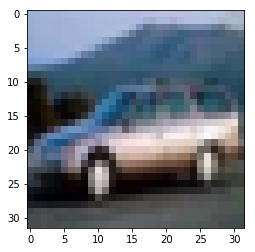

In [77]:
it = iter(loader_train)
x,y=next(it)

img = x[4].numpy().transpose((1,2,0))
#img = img * 0.5 + 0.5
plt.imshow(img);

In [78]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [79]:
gpu_dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [80]:
def train(model, loss_fn, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Linear Model

Use negative log likelihood loss with LogSoftmax.

The negative log likelihood loss is useful to train a classification
problem with `C` classes.

The input given through a forward call is expected to contain
log-probabilities of each class: input has to be a 2D Tensor of size
`(minibatch, C)`

Obtaining log-probabilities in a neural network is easily achieved by
adding a  `LogSoftmax`  layer in the last layer of your network.
You may use `CrossEntropyLoss` instead, if you prefer not to add an extra
layer.

In [137]:
class LinearNet(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(h[i], h[i+1]) for i in range(len(h) - 1)])
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        for lyr in self.layers:
            a = lyr(x)
            x = F.relu(a)
        return F.log_softmax(a, dim=-1)

In [138]:
model = LinearNet([32*32*3, 100, 100, 100, 100, 100, 10]).type(gpu_dtype)

loss_fn = nn.NLLLoss().type(gpu_dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.9642
Starting epoch 2 / 5
t = 100, loss = 1.7780
Starting epoch 3 / 5
t = 100, loss = 1.6860
Starting epoch 4 / 5
t = 100, loss = 1.6175
Starting epoch 5 / 5
t = 100, loss = 1.5840
Checking accuracy on validation set
Got 428 / 1000 correct (42.80)


### Simple CNN

In [142]:
model = nn.Sequential(nn.Conv2d(3, 32, kernel_size = 7),
                                nn.ReLU(inplace = True),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(kernel_size=2),
                      
                                Flatten(),
                                nn.Linear(5408, 1024),
                                nn.ReLU(inplace = True),
                                nn.Linear(1024,10)).type(gpu_dtype)

loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

In [143]:
torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.3967
Starting epoch 2 / 5
t = 100, loss = 1.1439
Starting epoch 3 / 5
t = 100, loss = 0.9472
Starting epoch 4 / 5
t = 100, loss = 0.8613
Starting epoch 5 / 5
t = 100, loss = 0.6729
Checking accuracy on validation set
Got 599 / 1000 correct (59.90)


### Multiple Conv Layers

In [141]:
class ConvNet(nn.Module):
    def __init__(self, h, c):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Conv2d(h[i], h[i+1], kernel_size=3, stride=2)
             for i in range(len(h) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(h[-1], c)
    
    def forward(self, x):
        for lyr in self.layers:
            x = F.relu(lyr(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.log_softmax(x, dim=-1)

In [148]:
model = ConvNet([3, 20, 40, 80], 10).type(gpu_dtype)

loss_fn = nn.NLLLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.9235
Starting epoch 2 / 5
t = 100, loss = 1.7553
Starting epoch 3 / 5
t = 100, loss = 1.6522
Starting epoch 4 / 5
t = 100, loss = 1.5978
Starting epoch 5 / 5
t = 100, loss = 1.5454
Checking accuracy on validation set
Got 435 / 1000 correct (43.50)


### Batch Norm

In [150]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [151]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [156]:
model = ConvBnNet([10, 20, 40, 80, 160], 10).type(gpu_dtype)

loss_fn = nn.NLLLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=5e-4)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.3542
Starting epoch 2 / 5
t = 100, loss = 1.1776
Starting epoch 3 / 5
t = 100, loss = 1.0794
Starting epoch 4 / 5
t = 100, loss = 0.9380
Starting epoch 5 / 5
t = 100, loss = 0.8870
Checking accuracy on validation set
Got 588 / 1000 correct (58.80)


In [157]:
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.7747
Starting epoch 2 / 5
t = 100, loss = 0.7354
Starting epoch 3 / 5
t = 100, loss = 0.7240
Starting epoch 4 / 5
t = 100, loss = 0.6517
Starting epoch 5 / 5
t = 100, loss = 0.6575
Checking accuracy on validation set
Got 680 / 1000 correct (68.00)


In [158]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.4880
Starting epoch 2 / 5
t = 100, loss = 0.4239
Starting epoch 3 / 5
t = 100, loss = 0.4447
Starting epoch 4 / 5
t = 100, loss = 0.4356
Starting epoch 5 / 5
t = 100, loss = 0.3950
Checking accuracy on validation set
Got 670 / 1000 correct (67.00)


### Conv-Relu-BatchNorm Net using PyTorch BatchNorm

In [159]:
class ConvReluBatchNorm(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.bn = nn.BatchNorm2d(nf)
        
    def forward(self, x):
        x = self.bn(F.relu(self.conv(x)))
        return x

In [160]:
class ConvReluBatchNormNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([ConvReluBatchNorm(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: 
            x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [161]:
model = ConvReluBatchNormNet([10, 20, 40, 80, 160], 10).type(gpu_dtype)

loss_fn = nn.NLLLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=5e-4)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.3439
Starting epoch 2 / 5
t = 100, loss = 1.1179
Starting epoch 3 / 5
t = 100, loss = 1.0044
Starting epoch 4 / 5
t = 100, loss = 0.9357
Starting epoch 5 / 5
t = 100, loss = 0.8829
Checking accuracy on validation set
Got 656 / 1000 correct (65.60)


In [162]:
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.8427
Starting epoch 2 / 5
t = 100, loss = 0.7849
Starting epoch 3 / 5
t = 100, loss = 0.6790
Starting epoch 4 / 5
t = 100, loss = 0.6527
Starting epoch 5 / 5
t = 100, loss = 0.6000
Checking accuracy on validation set
Got 672 / 1000 correct (67.20)


In [163]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.5064
Starting epoch 2 / 5
t = 100, loss = 0.4721
Starting epoch 3 / 5
t = 100, loss = 0.4867
Starting epoch 4 / 5
t = 100, loss = 0.4417
Starting epoch 5 / 5
t = 100, loss = 0.4207
Checking accuracy on validation set
Got 709 / 1000 correct (70.90)


In [164]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.4342
Starting epoch 2 / 5
t = 100, loss = 0.4094
Starting epoch 3 / 5
t = 100, loss = 0.4114
Starting epoch 4 / 5
t = 100, loss = 0.4070
Starting epoch 5 / 5
t = 100, loss = 0.3691
Checking accuracy on validation set
Got 705 / 1000 correct (70.50)


### Deeper Convnet

Use stride 1 Conv layers after each stride 2 conv to prevent size from reducing too quickly

In [168]:
class DeeperNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers1 = nn.ModuleList([ConvReluBatchNorm(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ConvReluBatchNorm(layers[i+1], layers[i + 1], stride=1)
            for i in range(len(layers) - 1)])
        
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l1, l2 in zip(self.layers1, self.layers2): 
            x = l1(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
model = DeeperNet([10, 20, 40, 80, 160], 10).type(gpu_dtype)

loss_fn = nn.NLLLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=5e-4)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.4290
Starting epoch 2 / 5
t = 100, loss = 1.1782
Starting epoch 3 / 5
t = 100, loss = 1.0197
Starting epoch 4 / 5
t = 100, loss = 0.9179
Starting epoch 5 / 5


In [170]:
check_accuracy(model, loader_val)

Checking accuracy on validation set
Got 682 / 1000 correct (68.20)


In [171]:
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.7812
Starting epoch 2 / 5
t = 100, loss = 0.6978
Starting epoch 3 / 5
t = 100, loss = 0.5768
Starting epoch 4 / 5
t = 100, loss = 0.5339
Starting epoch 5 / 5
t = 100, loss = 0.4568
Checking accuracy on validation set
Got 723 / 1000 correct (72.30)


In [172]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.3481
Starting epoch 2 / 5
t = 100, loss = 0.3183
Starting epoch 3 / 5
t = 100, loss = 0.2188
Starting epoch 4 / 5
t = 100, loss = 0.2111
Starting epoch 5 / 5
t = 100, loss = 0.1945
Checking accuracy on validation set
Got 730 / 1000 correct (73.00)


In [173]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.1784
Starting epoch 2 / 5
t = 100, loss = 0.1784
Starting epoch 3 / 5
t = 100, loss = 0.1307
Starting epoch 4 / 5
t = 100, loss = 0.0886
Starting epoch 5 / 5
t = 100, loss = 0.0973
Checking accuracy on validation set
Got 734 / 1000 correct (73.40)


### Resnet

In [176]:
class ResnetLayer(ConvReluBatchNorm):
    def forward(self, x):
        return x + super().forward(x)

In [178]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers1 = nn.ModuleList([ConvReluBatchNorm(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], stride=1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], stride=1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l1, l2, l3 in zip(self.layers1, self.layers2, self.layers3): 
            x = l3(l2(l1(x)))
            
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [179]:
model = Resnet([10, 20, 40, 80, 160], 10).type(gpu_dtype)

loss_fn = nn.NLLLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=5e-4)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.3973
Starting epoch 2 / 5
t = 100, loss = 1.1801
Starting epoch 3 / 5
t = 100, loss = 1.0845
Starting epoch 4 / 5
t = 100, loss = 0.9632
Starting epoch 5 / 5
t = 100, loss = 0.8868
Checking accuracy on validation set
Got 672 / 1000 correct (67.20)


In [180]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.1537
Starting epoch 2 / 5
t = 100, loss = 0.8289
Starting epoch 3 / 5
t = 100, loss = 0.7011
Starting epoch 4 / 5
t = 100, loss = 0.6564
Starting epoch 5 / 5
t = 100, loss = 0.5816
Checking accuracy on validation set
Got 729 / 1000 correct (72.90)


In [181]:
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.5087
Starting epoch 2 / 5
t = 100, loss = 0.4095
Starting epoch 3 / 5
t = 100, loss = 0.3693
Starting epoch 4 / 5
t = 100, loss = 0.3219
Starting epoch 5 / 5
t = 100, loss = 0.2665
Checking accuracy on validation set
Got 740 / 1000 correct (74.00)


In [182]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.1861
Starting epoch 2 / 5
t = 100, loss = 0.1026
Starting epoch 3 / 5
t = 100, loss = 0.1266
Starting epoch 4 / 5
t = 100, loss = 0.0896
Starting epoch 5 / 5
t = 100, loss = 0.0507
Checking accuracy on validation set
Got 781 / 1000 correct (78.10)


In [183]:
optimizer = optim.RMSprop(model.parameters(), lr=5e-5)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.0561
Starting epoch 2 / 5
t = 100, loss = 0.0286
Starting epoch 3 / 5
t = 100, loss = 0.0820
Starting epoch 4 / 5
t = 100, loss = 0.0310
Starting epoch 5 / 5
t = 100, loss = 0.0571
Checking accuracy on validation set
Got 783 / 1000 correct (78.30)


In [184]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-5)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.0316
Starting epoch 2 / 5
t = 100, loss = 0.0188
Starting epoch 3 / 5
t = 100, loss = 0.0242
Starting epoch 4 / 5
t = 100, loss = 0.0224
Starting epoch 5 / 5
t = 100, loss = 0.0241
Checking accuracy on validation set
Got 780 / 1000 correct (78.00)


### Add Dropout

In [190]:
class ResnetWithDropout(nn.Module):
    def __init__(self, layers, c, p):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.layers1 = nn.ModuleList([ConvReluBatchNorm(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], stride=1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], stride=1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l1, l2, l3 in zip(self.layers1, self.layers2, self.layers3): 
            x = l3(l2(l1(x)))
            
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [192]:
model = ResnetWithDropout([16, 32, 64, 128, 256], 10, 0.2).type(gpu_dtype)

loss_fn = nn.NLLLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.6142
Starting epoch 2 / 5
t = 100, loss = 1.1826
Starting epoch 3 / 5
t = 100, loss = 0.8804
Starting epoch 4 / 5
t = 100, loss = 0.7093
Starting epoch 5 / 5
t = 100, loss = 0.5877
Checking accuracy on validation set
Got 728 / 1000 correct (72.80)


In [193]:
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.5210
Starting epoch 2 / 5
t = 100, loss = 0.4546
Starting epoch 3 / 5
t = 100, loss = 0.3882
Starting epoch 4 / 5
t = 100, loss = 0.3170
Starting epoch 5 / 5
t = 100, loss = 0.2540
Checking accuracy on validation set
Got 792 / 1000 correct (79.20)


In [194]:
optimizer = optim.RMSprop(model.parameters(), lr=5e-5)
for i in range(2):
    train(model, loss_fn, optimizer, num_epochs=5)
    check_accuracy(model, loader_val)
    
optimizer = optim.RMSprop(model.parameters(), lr=1e-5)
for i in range(2):
    train(model, loss_fn, optimizer, num_epochs=5)
    check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.1685
Starting epoch 2 / 5
t = 100, loss = 0.1490
Starting epoch 3 / 5
t = 100, loss = 0.1286
Starting epoch 4 / 5
t = 100, loss = 0.1124
Starting epoch 5 / 5
t = 100, loss = 0.1010
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)
Starting epoch 1 / 5
t = 100, loss = 0.0981
Starting epoch 2 / 5
t = 100, loss = 0.0852
Starting epoch 3 / 5
t = 100, loss = 0.0625
Starting epoch 4 / 5
t = 100, loss = 0.0304
Starting epoch 5 / 5
t = 100, loss = 0.0258
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)
Starting epoch 1 / 5
t = 100, loss = 0.0257
Starting epoch 2 / 5
t = 100, loss = 0.0396
Starting epoch 3 / 5
t = 100, loss = 0.0459
Starting epoch 4 / 5
t = 100, loss = 0.0201
Starting epoch 5 / 5
t = 100, loss = 0.0299
Checking accuracy on validation set
Got 816 / 1000 correct (81.60)
Starting epoch 1 / 5
t = 100, loss = 0.0145
Starting epoch 2 / 5
t = 100, loss = 0.0300
Starting epoch 3 / 5
t = 100, loss = 0.0201
Startin

### Darknet

Reference https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb

In [198]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [202]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1 = conv_layer(ni, ni//2, ks=1)
        self.conv2 = conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): 
        return x + self.conv2(self.conv1(x))

In [203]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2, stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [206]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32).type(gpu_dtype)

loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

torch.cuda.random.manual_seed(12345)
model.apply(reset)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 1.8752
Starting epoch 2 / 5
t = 100, loss = 1.4551
Starting epoch 3 / 5
t = 100, loss = 1.2158
Starting epoch 4 / 5
t = 100, loss = 1.0537
Starting epoch 5 / 5
t = 100, loss = 0.8694
Checking accuracy on validation set
Got 636 / 1000 correct (63.60)


In [207]:
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

optimizer = optim.RMSprop(model.parameters(), lr=5e-5)
for i in range(2):
    train(model, loss_fn, optimizer, num_epochs=5)
    check_accuracy(model, loader_val)
    
optimizer = optim.RMSprop(model.parameters(), lr=1e-5)
for i in range(2):
    train(model, loss_fn, optimizer, num_epochs=5)
    check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.7644
Starting epoch 2 / 5
t = 100, loss = 0.6648
Starting epoch 3 / 5
t = 100, loss = 0.6034
Starting epoch 4 / 5
t = 100, loss = 0.5473
Starting epoch 5 / 5
t = 100, loss = 0.5244
Checking accuracy on validation set
Got 762 / 1000 correct (76.20)
Starting epoch 1 / 5
t = 100, loss = 0.3673
Starting epoch 2 / 5
t = 100, loss = 0.3365
Starting epoch 3 / 5
t = 100, loss = 0.3026
Starting epoch 4 / 5
t = 100, loss = 0.3045
Starting epoch 5 / 5
t = 100, loss = 0.2988
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)
Starting epoch 1 / 5
t = 100, loss = 0.2610
Starting epoch 2 / 5
t = 100, loss = 0.2324
Starting epoch 3 / 5
t = 100, loss = 0.2748
Starting epoch 4 / 5
t = 100, loss = 0.2118
Starting epoch 5 / 5
t = 100, loss = 0.2446
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)
Starting epoch 1 / 5
t = 100, loss = 0.2443
Starting epoch 2 / 5
t = 100, loss = 0.2183
Starting epoch 3 / 5
t = 100, loss = 0.2226
Startin

In [209]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-6)
train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, loader_val)

Starting epoch 1 / 5
t = 100, loss = 0.1960
Starting epoch 2 / 5
t = 100, loss = 0.1892
Starting epoch 3 / 5
t = 100, loss = 0.1620
Starting epoch 4 / 5
t = 100, loss = 0.1589
Starting epoch 5 / 5
t = 100, loss = 0.1603
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


In [211]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-7)
for i in range(5):
    train(model, loss_fn, optimizer, num_epochs=1)
    check_accuracy(model, loader_val)

Starting epoch 1 / 1
t = 100, loss = 0.1869
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)
Starting epoch 1 / 1
t = 100, loss = 0.1509
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)
Starting epoch 1 / 1
t = 100, loss = 0.1631
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)
Starting epoch 1 / 1
t = 100, loss = 0.1714
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)
Starting epoch 1 / 1
t = 100, loss = 0.1629
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


### Darknet with 1cycle learning using fastai

See https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb

In [222]:
import fastai

In [223]:
from fastai.conv_learner import *
PATH = Path("../../data/cifar/")
os.makedirs(PATH,exist_ok=True)

In [226]:
import os
import glob
import shutil
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
cwd = os.getcwd()
train_path = '../../data/cifar/train/'
# go through classes and make a directory for each one
for class_now in classes:
    path_now = train_path + class_now
    if not os.path.exists(path_now):
        os.makedirs(path_now)
# go through classes and match them with file names
# file names are e.g. '123_frog.png' so glob picks out all the e.g. frog files
for class_now in classes:
    identifier = train_path + '*' + class_now + '.png'
    class_files = glob.glob(identifier)
    file_destination = train_path + class_now
    # move all frog files to proper class directory
    for file_to_move in class_files:
        shutil.move(file_to_move, file_destination)

# do all the same but now for the test data
test_path = '../../data/cifar/test/'
for class_now in classes:
    path_now = test_path + class_now
    if not os.path.exists(path_now):
        os.makedirs(path_now)
for class_now in classes:
    identifier = test_path + '*' + class_now + '.png'
    class_files = glob.glob(identifier)
    file_destination = test_path + class_now
    for file_to_move in class_files:
        shutil.move(file_to_move, file_destination)


In [224]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

num_workers = num_cpus()//2
bs=256
sz=32


In [227]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)


In [228]:
m = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32)

In [229]:
lr = 1.3

In [230]:
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4

In [231]:
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.099655   4.288735   0.1889    
    1      1.835397   1.774035   0.3326                     
    2      1.610211   2.070968   0.2533                     
    3      1.472613   2.283549   0.2535                     
    4      1.296008   1.57996    0.4312                     
    5      1.126326   1.211259   0.555                      
    6      1.025275   1.069151   0.627                      
    7      0.936571   1.174674   0.5896                      
    8      0.847115   1.123143   0.5975                      
    9      0.778557   1.070792   0.6194                      
    10     0.735641   0.823801   0.7148                      
    11     0.677862   0.918517   0.6899                      
    12     0.639654   0.950375   0.6896                      
    13     0.615389   0.860501   0.7153                      
    14     0.579276   0.960796   0.6791                      
    15     0.55317    0.954072   

[array([0.28378]), 0.9073]

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [236]:
accuracy_np(to_np(probs), y)

0.9157

### Conclusion
We get 91.57% accuracy on CIFAR10 using 1cycle training with a Darknet architecture.